In [1]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
#import wandb
#from wandb.keras import WandbCallback
from sklearn.preprocessing import LabelEncoder
import os

In [2]:
# data load
train_data_path ="~/aiffel/dktc/data/train.csv"
train_data = pd.read_csv(train_data_path)
train_data.head()

,idx,class,conversation
0,0,협박 대화,지금 너 스스로를 죽여달라고 애원하는 것인가?\n 아닙니다. 죄송합니다.\n 죽을 ...
1,1,협박 대화,길동경찰서입니다.\n9시 40분 마트에 폭발물을 설치할거다.\n네?\n똑바로 들어 ...
2,2,기타 괴롭힘 대화,너 되게 귀여운거 알지? 나보다 작은 남자는 첨봤어.\n그만해. 니들 놀리는거 재미...
3,3,갈취 대화,어이 거기\n예??\n너 말이야 너. 이리 오라고\n무슨 일.\n너 옷 좋아보인다?...
4,4,갈취 대화,저기요 혹시 날이 너무 뜨겁잖아요? 저희 회사에서 이 선크림 파는데 한 번 손등에 ...


In [3]:
# label encoding
CLASS_NAMES = ['협박 대화', '갈취 대화', '직장 내 괴롭힘 대화', '기타 괴롭힘 대화']

class_dict = {}
for idx, class_name in enumerate(CLASS_NAMES):
    class_dict[class_name] = idx

train_data['class'] = train_data['class'].apply(lambda s: class_dict[s])

train_data.head()

,idx,class,conversation
0,0,0,지금 너 스스로를 죽여달라고 애원하는 것인가?\n 아닙니다. 죄송합니다.\n 죽을 ...
1,1,0,길동경찰서입니다.\n9시 40분 마트에 폭발물을 설치할거다.\n네?\n똑바로 들어 ...
2,2,3,너 되게 귀여운거 알지? 나보다 작은 남자는 첨봤어.\n그만해. 니들 놀리는거 재미...
3,3,1,어이 거기\n예??\n너 말이야 너. 이리 오라고\n무슨 일.\n너 옷 좋아보인다?...
4,4,1,저기요 혹시 날이 너무 뜨겁잖아요? 저희 회사에서 이 선크림 파는데 한 번 손등에 ...


In [4]:
# 중복 확인
train_data[train_data.duplicated(["class", "conversation"])]

,idx,class,conversation
392,392,3,병신이 아이스크림 먹게 돼 있냐?\n난 먹으면 안 돼? 그만 좀 해.\n당연히 안 ...
523,523,2,과장님. 저 이번에 휴가 좀 갔다와도 되겠습니까.?\n휴가? 왜??\n좀 쉬다가 오...
789,789,3,야 얘 이 쪽 손가락 세 개밖에 없다\n엥 손가락이 세개밖에 없을 수가 있어?\n봐...
824,824,3,이야 내동생 여자친구한테 편지쓰네?\n 아 형 돌려줘.\n 어디보자. 사랑하는 여친...
869,869,2,지현씨 나 소개팅 좀 시켜줘봐\n네? 저 주변에 아는 사람이 없어서요\n아 상사라 ...
...,...,...,...
3797,3797,3,너 이번 방학 때 쌍꺼풀 수술 하고왔지?\n아닌데?\n아니긴 뭐가 아니야. 눈이 이...
3798,3798,3,안녕하세요 지금 먹방 촬영중인데 촬영가능할까요?\n안돼요\n한번만 안될까요?\n안돼...
3855,3855,3,그 소문 진짜야? 너가 다른 애들 뒷담화하고 다녔다며?\n응? 나 그런 적 없는데?...
3874,3874,3,야 니 왤캐 못생겼냐?\n뭐라그랬냐?\n으 나 보고 말하지마 니 얼굴보면 토나올거 ...


In [5]:
# 중복 제거
train_data = train_data.drop_duplicates(subset=["class", "conversation"])

In [6]:
train_data[train_data.duplicated(["conversation"])]

,idx,class,conversation


In [7]:
print(train_data.shape)
train_data.head()

(3846, 3)


,idx,class,conversation
0,0,0,지금 너 스스로를 죽여달라고 애원하는 것인가?\n 아닙니다. 죄송합니다.\n 죽을 ...
1,1,0,길동경찰서입니다.\n9시 40분 마트에 폭발물을 설치할거다.\n네?\n똑바로 들어 ...
2,2,3,너 되게 귀여운거 알지? 나보다 작은 남자는 첨봤어.\n그만해. 니들 놀리는거 재미...
3,3,1,어이 거기\n예??\n너 말이야 너. 이리 오라고\n무슨 일.\n너 옷 좋아보인다?...
4,4,1,저기요 혹시 날이 너무 뜨겁잖아요? 저희 회사에서 이 선크림 파는데 한 번 손등에 ...


In [8]:
# reindexing
train_data = train_data.reset_index(drop=True)

In [9]:
corpus = train_data["conversation"]
corpus.head()

0    지금 너 스스로를 죽여달라고 애원하는 것인가?\n 아닙니다. 죄송합니다.\n 죽을 ...
1    길동경찰서입니다.\n9시 40분 마트에 폭발물을 설치할거다.\n네?\n똑바로 들어 ...
2    너 되게 귀여운거 알지? 나보다 작은 남자는 첨봤어.\n그만해. 니들 놀리는거 재미...
3    어이 거기\n예??\n너 말이야 너. 이리 오라고\n무슨 일.\n너 옷 좋아보인다?...
4    저기요 혹시 날이 너무 뜨겁잖아요? 저희 회사에서 이 선크림 파는데 한 번 손등에 ...
Name: conversation, dtype: object

In [10]:
corpus[392]

'회식 갈거지?\n오늘 몸이 좀 안 좋아서.\n몸관리를 왜 이렇게 못해.\n한다고 하는데 뜻대로 안되네요.\n이번 회식은 과장님 축하 위한거니 되도록이면 모두 참석 했으면 하는데.\n죄송합니다.\n그 정도로 심한 것 같지 않은데 잠깐이라도 참석해서 더 말 안나오게 해.\n네 알겠습니다.\n사람이 참 융통성이 없어. \n죄송합니다.'

In [11]:
# 불용어 제거
import re

def preprocess_sentence(sentence):
    sentence = sentence.lower().strip()

    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r"[^a-zA-Zㄱ-ㅎ가-힣ㅏ-ㅣ?.!,]+", " ", sentence)
    
    sentence = sentence.strip()

    return sentence

In [12]:
# tokenizing
import sentencepiece as spm

def generate_spm_tokenizer(corpus,
                        vocab_size,
                        lang="ko",
                        pad_id=0,
                        bos_id=1,
                        eos_id=2,
                        unk_id=3):
    # sentencepiece train을 위해 해당 corpus를 별도 파일로 만듬.
    temp_file = f"{lang}_corpus.txt"
    with open(temp_file, "w") as f:
        for sen in corpus:
            f.write(sen)
            f.write("\n")
    
    #  sentencepiece train
    model_name = f"{lang}_spm"
    spm.SentencePieceTrainer.train(input=temp_file, 
                                   model_prefix=model_name, 
                                   vocab_size=vocab_size, 
                                   pad_id=pad_id, 
                                   bos_id=bos_id, 
                                   eos_id=eos_id, 
                                   unk_id=unk_id)
    
    #  sentencepiece load
    tokenizer = spm.SentencePieceProcessor()
    tokenizer.Load(model_name + ".model")
    
    return tokenizer

In [13]:
corpus = [preprocess_sentence(s) for s in corpus]

In [14]:
corpus[0]

'지금 너 스스로를 죽여달라고 애원하는 것인가 ? 아닙니다 . 죄송합니다 . 죽을 거면 혼자 죽지 우리까지 사건에 휘말리게 해 ? 진짜 죽여버리고 싶게 . 정말 잘못했습니다 . 너가 선택해 . 너가 죽을래 네 가족을 죽여줄까 . 죄송합니다 . 정말 잘못했습니다 . 너에게는 선택권이 없어 . 선택 못한다면 너와 네 가족까지 모조리 죽여버릴거야 . 선택 못하겠습니다 . 한번만 도와주세요 . 그냥 다 죽여버려야겠군 . 이의 없지 ? 제발 도와주세요 .'

In [15]:
len_list = list(map(lambda s: len(s), corpus))
print(max(len_list))
print(min(len_list))

909
41


sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input: ko_corpus.txt
  input_format: 
  model_prefix: ko_spm
  model_type: UNIGRAM
  vocab_size: 10000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 3
  bos_id: 1
  eos_id: 2
  pad_id: 0
  unk_piece: <unk>
  bos_piece: <s>
  eos_piece: </s>
  pad_piece: <pad>
  unk_surface:  ⁇ 
}
normalizer_spec {
  name: nmt_nfkc
  add_dummy_prefix: 1
  remove_extra_whitespaces: 1
  escape_wh

<AxesSubplot:ylabel='Count'>

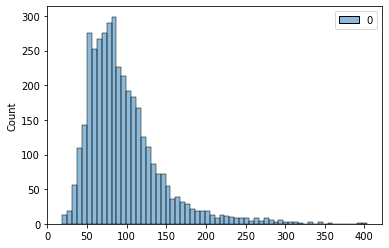

In [16]:
vocab_size = 10000

spm_tokenizer = generate_spm_tokenizer(corpus, vocab_size)
tokenized_corpus = []

# 토큰의 길이가 50 이하인 문장만 남깁니다. 
for idx in range(len(corpus)):
    tokenized_corpus.append(spm_tokenizer.EncodeAsIds(corpus[idx]))
    
len_tokenized = [map(lambda s: len(s), tokenized_corpus)]
import seaborn as sns
sns.histplot(len_tokenized)

---

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline

In [19]:
from sklearn.model_selection import train_test_split

max_len = 100

#X_train, X_rem, y_train, y_rem = train_test_split(tokenized_corpus, train_data['class'], train_size=0.8, random_state=42)
#X_val, X_test, y_val, y_test = train_test_split(X_rem, y_rem, test_size=0.5)

X_train, X_val, y_train, y_val = train_test_split(tokenized_corpus, train_data['class'], train_size=0.2, random_state=42)


print(len(X_train)), print(len(y_train))
print(len(X_val)), print(len(y_val))
#print(len(X_test)), print(len(y_test))

X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train, padding='pre', maxlen=max_len)
X_val = tf.keras.preprocessing.sequence.pad_sequences(X_val, padding='pre', maxlen=max_len)
#X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, padding='pre', maxlen=max_len)

769
769
3077
3077


In [62]:
inputs = keras.layers.Input(shape=(None,))
x = keras.layers.Embedding(vocab_size, 128)(inputs)

#x = keras.layers.LSTM(256, return_sequences=True)(x)
#x = keras.layers.SimpleRNN(128)(x)
#x = keras.layers.LSTM(128)(x)
x = keras.layers.GRU(128)(x)
#x = keras.layers.Conv1D(128, kernel_size=3, padding='same')
#x = keras.layers.Bidirectional(keras.layers.LSTM(128))(x)

x = keras.layers.Dense(256, activation="relu")(x)
x = keras.layers.Dense(4, activation="softmax")(x)

model = keras.Model(inputs, x)

model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding_4 (Embedding)      (None, None, 128)         1280000   
_________________________________________________________________
gru (GRU)                    (None, 128)               99072     
_________________________________________________________________
dense_8 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_9 (Dense)              (None, 4)                 1028      
Total params: 1,413,124
Trainable params: 1,413,124
Non-trainable params: 0
_________________________________________________________________


In [63]:
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

In [64]:
hist = model.fit(X_train, 
                 y_train, 
                 validation_data=(X_val, y_val), 
                 batch_size=32, 
                 epochs = 10,)

Epoch 1/10
25/25 [==============================] - 2s 35ms/step - loss: 1.3814 - accuracy: 0.2783 - val_loss: 1.3712 - val_accuracy: 0.3149
Epoch 2/10
25/25 [==============================] - 0s 16ms/step - loss: 1.2769 - accuracy: 0.4252 - val_loss: 1.4990 - val_accuracy: 0.3260
Epoch 3/10
25/25 [==============================] - 0s 16ms/step - loss: 0.6391 - accuracy: 0.8023 - val_loss: 1.1776 - val_accuracy: 0.5863
Epoch 4/10
25/25 [==============================] - 0s 16ms/step - loss: 0.1082 - accuracy: 0.9675 - val_loss: 1.3914 - val_accuracy: 0.5954
Epoch 5/10
25/25 [==============================] - 0s 16ms/step - loss: 0.0231 - accuracy: 0.9922 - val_loss: 1.7057 - val_accuracy: 0.5710
Epoch 6/10
25/25 [==============================] - 0s 16ms/step - loss: 0.0121 - accuracy: 0.9961 - val_loss: 1.5058 - val_accuracy: 0.6051
Epoch 7/10
25/25 [==============================] - 0s 17ms/step - loss: 0.0110 - accuracy: 1.0000 - val_loss: 1.6700 - val_accuracy: 0.5879
Epoch 8/10
25

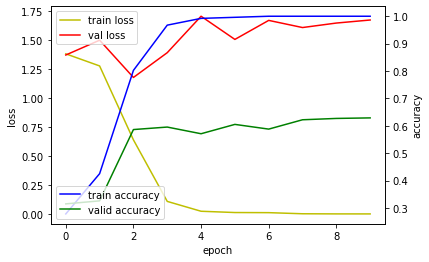

In [65]:
fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label = 'train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label = 'val loss')

acc_ax.plot(hist.history['accuracy'], 'b', label = 'train accuracy')
acc_ax.plot(hist.history['val_accuracy'], 'g', label = 'valid accuracy')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuracy')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

---

In [66]:
test_data = pd.read_json("~/aiffel/dktc/data/test.json")
test_data = test_data.transpose()
test_data.head()

,text
t_000,아가씨 담배한갑주소 네 4500원입니다 어 네 지갑어디갔지 에이 버스에서 잃어버렸나...
t_001,우리팀에서 다른팀으로 갈 사람 없나? 그럼 영지씨가 가는건 어때? 네? 제가요? ...
t_002,너 오늘 그게 뭐야 네 제가 뭘 잘못했나요.? 제대로 좀 하지 네 똑바로 좀 하지 ...
t_004,아무튼 앞으로 니가 내 와이파이야. .응 와이파이 온. 켰어. 반말? 주인님이라고도...
t_005,그러니까 빨리 말해. 선생님 제발 살려주십시오. 비밀번호 틀릴 때마다 손톱 하나씩...


In [67]:
test_corpus = [preprocess_sentence(s) for s in test_data["text"]]
tokenized_test_corpus = []
for idx in range(len(test_corpus)):
    tokenized_test_corpus.append(spm_tokenizer.EncodeAsIds(test_corpus[idx]))
    
X_test = tf.keras.preprocessing.sequence.pad_sequences(tokenized_test_corpus, padding='post', maxlen=max_len)

In [68]:
predicted = model.predict(X_test)

In [69]:
import numpy as np

predicted = np.argmax(predicted, axis=-1)

---

In [70]:
submission = pd.read_csv("~/aiffel/dktc/data/submission.csv")

In [71]:
submission['class'] = predicted

In [72]:
submission.head()

,file_name,class
0,t_000,2
1,t_001,2
2,t_002,2
3,t_004,2
4,t_005,0


In [73]:
#submission.to_csv("LSTM.csv", index=False) ## ACCURACY: 0.54
#submission.to_csv("Bidirectional_LSTM.csv", index=False) ## ACCURACY: 0.525
#submission.to_csv("SimpleRNN.csv", index=False) ## ACCURACY: 0.245
submission.to_csv("GRU.csv", index=False) ## ACCURACY: 0.42


In [74]:
len(submission)

400